# Project 5 : Predict markets stocks of Google, Facebook & Amazon.

## MAP670G - Data Stream (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

<br>
<img src="Google_Facebook_Amazon.PNG" width="600" height="600">
<br>

__Project 5 : Collect trading data using Yahoo finance API and use online regression to predict markets stocks of Google, Facebook & Amazon.__

__Option 2 :__ For each of these 5 countries, use 1 major industry stock data
For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.
This option was initially given in the project.

For each option, each group should use at least 3 different data streams, with online and adaptive regression on RIVER (such as https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/) and compare the performances with batch regression model (scikit-learn).

__ToDo:__ Compare online Regression vs Batch Regression and discuss the performance.

__Bonus :__ Use recent stock market data (from January to March 2022).

__Online resources:__ 
You can use the Python library to collect Yahoo Finance data in streaming https://pypi.org/project/yfinance/
You can compute time-series statistics and moving averages (MACD) for features engineering https://www.statsmodels.org/stable/tsa.html


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Libraries

In [2]:
!pip3 install --quiet -r requirements.txt

In [47]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import kafka
from kafka.admin import KafkaAdminClient, NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
print("kafka version : {}". format(kafka.__version__))

import yfinance as yf
print("yfinance version : {}". format(yf.__version__))

import statsmodels
print("statsmodels version : {}". format(statsmodels.__version__))
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

import sklearn
print("scikit-learn version : {}". format(sklearn.__version__))

import river
from river import base
from river import drift
from river import datasets
from river import anomaly
from river.anomaly.hst import HalfSpaceTrees, make_padded_tree
from river import compose
from river import metrics
from river import preprocessing

print("river version : {}". format(river.__version__))

import time
from time import perf_counter
from datetime import datetime

import math

import pprint

import json

import urllib.request

import warnings
warnings.filterwarnings('ignore')

print("====================================")

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
IPython version: 7.27.0
NumPy version: 1.20.3
SciPy version: 1.7.1
pandas version: 1.3.2
matplotlib version: 3.4.2
seaborn version : 0.11.2
kafka version : 2.0.2
yfinance version : 0.1.70
statsmodels version : 0.13.2
scikit-learn version : 1.0.1
river version : 0.9.0


## Utility functions

In [4]:
def printmd(text, couleur=None):
    """
    Printing of the string text by choosing the style (for example bold) and the color (couleur)
    """
    colorstr = "<span style='color:{}'>{}</span>".format(couleur, text)
    display(Markdown(colorstr))

## Lancement des Serveurs
<p><b>LANCEMENT DU SERVEUR ZOOKEEPER ET DU SERVEUR KAFKA</b></p>
<p> Dans un <b>premier terminal</b>, lancer les commandes suivantes :
<p>cd %KAFKA_DIR%
<p>.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
<p>  </p>
<p> Dans un <b>second terminal</b>, lancer les commandes suivantes
<p>cd %KAFKA_DIR%
<p>.\bin\windows\kafka-server-start.bat .\config\server.properties
<p>  -- </p>
<p>we assume that Zookeeper is running default on localhost:2181 and Kafka on localhost:9092.</p>

# Get stock market data from Google, Facebook and Amazon

In [5]:
the_GAF = ["google", "amazon", "facebook"]
All_the_companies = ["google",
                     "facebook",
                     "amazon",
                     "total",
                     "gazprom",
                     "alibaba",
                     "bnp_paribas",
                     "BP",
                     "ferrari"]

tick = {}
tick["google"] = "GOOG"
tick["facebook"] = "FB"
tick["amazon"] = "AMZN"
tick["total"] = "TTE"
tick["gazprom"] = "OGZPY"
tick["alibaba"] = "BABA"
tick["bnp_paribas"] = "BNPQY"
tick["BP"] = "BP"
tick["ferrari"] = "RACE"

the_GAF_tickers = " ".join(map(str, [v for k, v in tick.items() if k in the_GAF]))
all_the_tickers = " ".join(map(str, [v for v in tick.values()]))
GAF_tick = yf.Tickers(the_GAF_tickers)
ALL_tick = yf.Tickers(all_the_tickers)

google = GAF_tick.tickers[tick["google"]]
facebook = GAF_tick.tickers[tick["facebook"]]
amazon = GAF_tick.tickers[tick["amazon"]]

total = yf.Ticker(tick["total"])
gazprom = yf.Ticker(tick["gazprom"])
alibaba = yf.Ticker(tick["alibaba"])
bnp_paribas = yf.Ticker(tick["bnp_paribas"])
BP = yf.Ticker(tick["BP"])
ferrari = yf.Ticker(tick["ferrari"])

In [6]:
# get stock info
google_info = google.info
facebook_info = facebook.info
amazon_info = amazon.info
total_info = total.info
gazprom_info = gazprom.info
alibaba_info = alibaba.info
bnp_paribas_info = bnp_paribas.info
BP_info = BP.info
ferrari_info = ferrari.info

stock_info = [google_info, facebook_info, amazon_info,
              total_info, gazprom_info, alibaba_info,
              bnp_paribas_info, BP_info, ferrari_info]

for info in stock_info:
    print("{} - sector: {}; country: {}; logo: {}" \
        .format(info["shortName"],
                info["sector"],
                info["country"],
                info["logo_url"]))

Alphabet Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/abc.xyz
Meta Platforms, Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/investor.fb.com
Amazon.com, Inc. - sector: Consumer Cyclical; country: United States; logo: https://logo.clearbit.com/amazon.com
TotalEnergies SE - sector: Energy; country: France; logo: https://logo.clearbit.com/totalenergies.com
GAZPROM PUBLIC JOINT STOCK COMP - sector: Energy; country: Russia; logo: https://logo.clearbit.com/gazprom.com
Alibaba Group Holding Limited - sector: Consumer Cyclical; country: China; logo: https://logo.clearbit.com/alibabagroup.com
BNP PARIBAS ADR EACH REPR 1/2 O - sector: Financial Services; country: France; logo: https://logo.clearbit.com/group.bnpparibas
BP p.l.c. - sector: Energy; country: United Kingdom; logo: https://logo.clearbit.com/bp.com
Ferrari N.V. - sector: Consumer Cyclical; country: Italy; logo: https://logo.clearbit.com/f

## Daily stock prices for the last 20 years

In [7]:
deb = "2002-01-01"
fin = "2022-03-31"
temps = perf_counter()
data_history = yf.download(all_the_tickers, start=deb, end=fin, group_by='ticker')
temps_recuperation_donnees = perf_counter() - temps
print("{} secondes".format(temps_recuperation_donnees))

[*********************100%***********************]  9 of 9 completed
2.506020499999977 secondes


In [8]:
data_history

RACE                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2001-12-31         NaN         NaN         NaN         NaN         NaN   
2002-01-02         NaN         NaN         NaN         NaN         NaN   
2002-01-03         NaN         NaN         NaN         NaN         NaN   
2002-01-04         NaN         NaN         NaN         NaN         NaN   
2002-01-07         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-03-08  186.699997  188.929993  178.869995  181.479996  181.479996   
2022-03-09  195.910004  199.199997  193.514999  197.720001  197.720001   
2022-03-10  193.800003  194.520004  189.770004  192.960007  192.960007   
2022-03-11  195.259995  195.539993  189.750000  190.449997  190.449997   
2022-03-14  195.259995  195.479996  194.759995  195.250000  195.250000   

                             BABA                                     ...  \
               Volume        Open        High        Low       Close  ...   
Date                                                                  ...   
2001-12-31        NaN         NaN         NaN        NaN         NaN  ...   
2002-01-02        NaN         NaN         NaN        NaN         NaN  ...   
2002-01-03        NaN         NaN         NaN        NaN         NaN  ...   
2002-01-04        NaN         NaN         NaN        NaN         NaN  ...   
2002-01-07        NaN         NaN         NaN        NaN         NaN  ...   
...               ...         ...         ...        ...         ...  ...   
2022-03-08  1001300.0   99.320000  100.910004  95.570000   97.500000  ...   
2022-03-09   731900.0  100.260002  100.970001  98.320000  100.930000  ...   
2022-03-10   658200.0   95.190002   95.699997  90.820000   92.919998  ...   
2022-03-11   459500.0   93.260002   93.949997  86.680000   86.709999  ...   
2022-03-14    16638.0   93.260002   80.830002  78.790001   79.160004  ...   

                  TTE                                     BNPQY             \
                  Low      Close  Adj Close   Volume       Open       High   
Date                                                                         
2001-12-31  35.049999  35.119999  12.362158   221400        NaN        NaN   
2002-01-02  35.230000  35.450001  12.478315  1873400        NaN        NaN   
2002-01-03  35.369999  35.634998  12.543436   891600        NaN        NaN   
2002-01-04  35.505001  35.799999  12.601514  1500400        NaN        NaN   
2002-01-07  35.275002  35.365002  12.448400   351000        NaN        NaN   
...               ...        ...        ...      ...        ...        ...   
2022-03-08  48.990002  50.160000  50.160000  8863300  26.360001  27.139999   
2022-03-09  50.009998  50.669998  50.669998  4681600  28.160000  28.889999   
2022-03-10  50.090000  50.790001  50.790001  3122600  27.350000  27.690001   
2022-03-11  49.599998  49.650002  49.650002  2928500  27.190001  27.340000   
2022-03-14  50.290001  50.349998  50.349998   185052        NaN        NaN   

                                                        
                  Low      Close  Adj Close     Volume  
Date                                                    
2001-12-31        NaN        NaN        NaN        NaN  
2002-01-02        NaN        NaN        NaN        NaN  
2002-01-03        NaN        NaN        NaN        NaN  
2002-01-04        NaN        NaN        NaN        NaN  
2002-01-07        NaN        NaN        NaN        NaN  
...               ...        ...        ...        ...  
2022-03-08  25.260000  26.129999  26.129999   858100.0  
2022-03-09  27.959999  28.280001  28.280001   778800.0  
2022-03-10  26.900000  27.200001  27.200001   507200.0  
2022-03-11  26.360001  26.360001  26.360001  3100400.0  
2022-03-14        NaN        NaN        NaN        NaN  

[5086 rows

In [9]:
data_history.describe()

RACE                                                      \
              Open         High          Low        Close    Adj Close   
count  1610.000000  1610.000000  1610.000000  1610.000000  1610.000000   
mean    134.560624   135.700492   133.375351   134.529105   132.720224   
std      61.211578    61.644245    60.723098    61.157658    61.804665   
min      32.290001    32.480000    31.660000    32.000000    30.428837   
25%      85.037502    85.760002    84.984999    85.549999    83.185589   
50%     133.135002   134.635002   132.004997   133.005005   130.303856   
75%     181.279995   182.810001   180.444996   181.555000   180.779644   
max     275.369995   278.779999   273.000000   275.299988   275.299988   

                            BABA                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  1.610000e+03  1884.000000  1884.000000  1884.000000  1884.000000  ...   
mean   5.177783e+05   153.774952   155.555990   151.652060   153.621943  ...   
std    7.442300e+05    59.637915    60.228067    58.847590    59.585311  ...   
min    1.663800e+04    57.299999    58.650002    57.200001    57.389999  ...   
25%    2.596750e+05    96.414999    97.432497    95.565001    96.572502  ...   
50%    3.821500e+05   161.605003   163.209999   159.114998   160.930000  ...   
75%    5.697500e+05   191.557495   194.472496   189.317501   191.874996  ...   
max    2.249880e+07   313.500000   319.320007   308.910004   317.140015  ...   

               TTE                                                BNPQY  \
               Low        Close    Adj Close        Volume         Open   
count  5086.000000  5086.000000  5086.000000  5.086000e+03  4726.000000   
mean     53.191424    53.632270    31.356522  2.082819e+06    33.409862   
std      11.105620    11.154401     9.996418  1.489769e+06     9.607995   
min      22.129999    24.760000    11.126491  1.850520e+05    13.450000   
25%      46.776251    47.242501    25.416873  1.127000e+06    26.700001   
50%      51.905001    52.355000    30.899718  1.688550e+06    31.900000   
75%      59.482501    59.925000    37.653689  2.587050e+06    37.900002   
max      89.790001    89.940002    60.029999  2.705530e+07    63.900002   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  4726.000000  4726.000000  4726.000000  4726.000000  4.726000e+03  
mean     33.715643    33.089006    33.423013    23.376507  1.679524e+05  
std       9.654995     9.538721     9.608051     5.716749  3.392176e+05  
min      13.460000    13.180000    13.280000     8.100594  0.000000e+00  
25%      26.910000    26.432500    26.680000    19.487328  4.420000e+04  
50%      32.155001    31.650000    31.950001    23.407779  8.270000e+04  
75%      38.247500    37.625001    37.897501    27.425617  1.645000e+05  
max      64.199997    63.000000    63.900002    38.200001  5.604400e+06  

[8 rows x 54 columns]

In [10]:
data_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5086 entries, 2001-12-31 to 2022-03-14
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (RACE, Open)        1610 non-null   float64
 1   (RACE, High)        1610 non-null   float64
 2   (RACE, Low)         1610 non-null   float64
 3   (RACE, Close)       1610 non-null   float64
 4   (RACE, Adj Close)   1610 non-null   float64
 5   (RACE, Volume)      1610 non-null   float64
 6   (BABA, Open)        1884 non-null   float64
 7   (BABA, High)        1884 non-null   float64
 8   (BABA, Low)         1884 non-null   float64
 9   (BABA, Close)       1884 non-null   float64
 10  (BABA, Adj Close)   1884 non-null   float64
 11  (BABA, Volume)      1884 non-null   float64
 12  (FB, Open)          2471 non-null   float64
 13  (FB, High)          2471 non-null   float64
 14  (FB, Low)           2471 non-null   float64
 15  (FB, Close)         2471 non-null   f

In [11]:
data_history.columns

MultiIndex([( 'RACE',      'Open'),
            ( 'RACE',      'High'),
            ( 'RACE',       'Low'),
            ( 'RACE',     'Close'),
            ( 'RACE', 'Adj Close'),
            ( 'RACE',    'Volume'),
            ( 'BABA',      'Open'),
            ( 'BABA',      'High'),
            ( 'BABA',       'Low'),
            ( 'BABA',     'Close'),
            ( 'BABA', 'Adj Close'),
            ( 'BABA',    'Volume'),
            (   'FB',      'Open'),
            (   'FB',      'High'),
            (   'FB',       'Low'),
            (   'FB',     'Close'),
            (   'FB', 'Adj Close'),
            (   'FB',    'Volume'),
            ('OGZPY',      'Open'),
            ('OGZPY',      'High'),
            ('OGZPY',       'Low'),
            ('OGZPY',     'Close'),
            ('OGZPY', 'Adj Close'),
            ('OGZPY',    'Volume'),
            ( 'AMZN',      'Open'),
            ( 'AMZN',      'High'),
            ( 'AMZN',       'Low'),
            ( 'AMZN',     'C

## Recent stock market data (from January to March 2022).

In [50]:
deb = "2021-01-01"
fin = "2022-03-31"
interval = "1h"
temps = perf_counter()
data_recent = yf.download(all_the_tickers, start=deb, end=fin, interval=interval, group_by='ticker')
temps_recuperation_donnees = perf_counter() - temps
print("{} secondes".format(temps_recuperation_donnees))

[*********************100%***********************]  9 of 9 completed
5.206658400002198 secondes


In [51]:
data_recent

BABA                                      \
                                 Open        High         Low       Close   
2021-01-04 09:30:00-05:00  226.699997  230.380005  225.449997  227.750000   
2021-01-04 10:30:00-05:00  227.679993  227.850006  225.149994  226.759995   
2021-01-04 11:30:00-05:00  226.710007  227.800003  225.039993  225.539993   
2021-01-04 12:30:00-05:00  225.527893  226.649994  225.059998  226.360001   
2021-01-04 13:30:00-05:00  226.380005  227.619995  226.139999  227.119995   
...                               ...         ...         ...         ...   
2022-03-14 12:47:39-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:47:41-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:05-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:06-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:07-04:00   78.720001   78.720001   78.720001   78.720001   

                                                         GOOG               \
                            Adj Close     Volume         Open         High   
2021-01-04 09:30:00-05:00  227.750000  9629223.0  1758.420044  1760.640015   
2021-01-04 10:30:00-05:00  226.759995  4899605.0  1749.130005  1757.816040   
2021-01-04 11:30:00-05:00  225.539993  2398786.0  1730.550049  1731.800049   
2021-01-04 12:30:00-05:00  226.360001  1817918.0  1716.150024  1723.199951   
2021-01-04 13:30:00-05:00  227.119995  1429753.0  1722.466187  1729.150024   
...                               ...        ...          ...          ...   
2022-03-14 12:47:39-04:00         NaN        NaN          NaN          NaN   
2022-03-14 12:47:41-04:00         NaN        NaN  2548.129883  2548.129883   
2022-03-14 12:48:05-04:00         NaN        NaN          NaN          NaN   
2022-03-14 12:48:06-04:00         NaN        NaN          NaN          NaN   
2022-03-14 12:48:07-04:00   78.720001        0.0          NaN          NaN   

                                                     ...        RACE  \
                                   Low        Close  ...         Low   
2021-01-04 09:30:00-05:00  1740.949951  1748.239990  ...  230.470001   
2021-01-04 10:30:00-05:00  1725.000000  1730.589966  ...  228.850006   
2021-01-04 11:30:00-05:00  1710.880005  1716.534424  ...  227.220001   
2021-01-04 12:30:00-05:00  1707.849976  1722.277466  ...  227.119995   
2021-01-04 13:30:00-05:00  1720.229980  1724.395020  ...  226.710007   
...                                ...          ...  ...         ...   
2022-03-14 12:47:39-04:00          NaN          NaN  ...         NaN   
2022-03-14 12:47:41-04:00  2548.129883  2548.129883  ...         NaN   
2022-03-14 12:48:05-04:00          NaN          NaN  ...         NaN   
2022-03-14 12:48:06-04:00          NaN          NaN  ...         NaN   
2022-03-14 12:48:07-04:00          NaN          NaN  ...         NaN   

                                                                    FB  \
                                Close   Adj Close   Volume        Open   
2021-01-04 09:30:00-05:00  230.729996  230.729996      0.0  273.750000   
2021-01-04 10:30:00-05:00  230.850006  230.850006  37451.0  271.269989   
2021-01-04 11:30:00-05:00  228.107697  228.107697  49115.0  268.220001   
2021-01-04 12:30:00-05:00  228.949997  228.949997  17811.0  266.920013   
2021-01-04 13:30:00-05:00  226.955002  226.955002  34929.0  268.440002   
...                               ...         ...      ...         ...   
2022-03-14 12:47:39-04:00         NaN         NaN      NaN         NaN   
2022-03-14 12:47:41-04:00         NaN         NaN      NaN         NaN   
2022-03-14 12:48:05-04:00         NaN         NaN      NaN         NaN   
2022-03-14 12:48:06-04:00         NaN         NaN      NaN  187.429993   
2022-03-14 12:48:07-04:00         NaN         NaN      NaN         NaN   

                                                                           \
                                 High  

In [52]:
data_recent.tail(50)

BABA                                      \
                                 Open        High         Low       Close   
2022-03-04 13:30:00-05:00  101.699997  101.730003  100.375000  100.657204   
2022-03-04 14:30:00-05:00  100.639999  101.120003  100.500000  100.900002   
2022-03-04 15:30:00-05:00  100.889999  100.940002  100.029999  100.620003   
2022-03-07 09:30:00-05:00   99.559998  103.360001   99.559998  100.449997   
2022-03-07 10:30:00-05:00  100.440002  101.379997   99.809998  100.806297   
2022-03-07 11:30:00-05:00  100.809998  100.966003  100.120003  100.470001   
2022-03-07 12:30:00-05:00  100.470001  102.059998  100.360001  100.550003   
2022-03-07 13:30:00-05:00  100.540001  100.930000  100.360001  100.699997   
2022-03-07 14:30:00-05:00  100.690002  100.769997   98.910004   99.339996   
2022-03-07 15:30:00-05:00   99.320000   99.470001   98.599998   98.680000   
2022-03-08 09:30:00-05:00   99.320000   99.870003   95.570000   96.980003   
2022-03-08 10:30:00-05:00   96.959999   98.919998   96.320000   98.190002   
2022-03-08 11:30:00-05:00   98.230003  100.910004   97.699402  100.283501   
2022-03-08 12:30:00-05:00  100.360001  100.863998   99.580002   99.739098   
2022-03-08 13:30:00-05:00   99.760002   99.779999   97.949997   98.860001   
2022-03-08 14:30:00-05:00   98.849998   99.279999   98.110001   98.129997   
2022-03-08 15:30:00-05:00   98.160004   98.410004   97.440002   97.500000   
2022-03-09 09:30:00-05:00  100.260002  100.970001   98.320000  100.617996   
2022-03-09 10:30:00-05:00  100.639999  100.720001   99.389999   99.730003   
2022-03-09 11:30:00-05:00   99.750000  100.669998   99.510002   99.760002   
2022-03-09 12:30:00-05:00   99.750000  100.410004   99.400002   99.875000   
2022-03-09 13:30:00-05:00   99.889999  100.059998   99.110001   99.644997   
2022-03-09 14:30:00-05:00   99.650002  100.559998   99.614998  100.169998   
2022-03-09 15:30:00-05:00  100.150002  100.970001  100.110001  100.915001   
2022-03-10 09:30:00-05:00   95.190002   95.699997   92.110001   92.933502   
2022-03-10 10:30:00-05:00   92.910004   92.999100   91.080002   91.255302   
2022-03-10 11:30:00-05:00   91.260002   92.547997   90.820000   91.680000   
2022-03-10 12:30:00-05:00   91.690002   92.120003   91.139999   92.019997   
2022-03-10 13:30:00-05:00   92.029999   93.160004   91.894997   92.786697   
2022-03-10 14:30:00-05:00   92.790001   92.945000   92.180000   92.782402   
2022-03-10 15:30:00-05:00   92.790001   93.120003   92.589996   92.940002   
2022-03-11 09:30:00-05:00   93.260002   93.949997   87.291496   88.360001   
2022-03-11 10:30:00-05:00   88.349998   90.580002   87.830002   89.260002   
2022-03-11 11:30:00-05:00   89.255798   89.304802   88.099998   88.229103   
2022-03-11 12:30:00-05:00   88.220001   88.440002   87.589996   88.355003   
2022-03-11 13:30:00-05:00   88.355003   88.549896   87.370003   88.240997   
2022-03-11 14:30:00-05:00   88.250000   88.300003   87.084999   87.275002   
2022-03-11 15:30:00-05:00   87.270401   87.419998   86.680000   86.699997   
2022-03-14 09:30:00-04:00   80.099998   82.449997   77.699997   81.000000   
2022-03-14 10:30:00-04:00   80.989998   81.349998   80.019997   80.800102   
2022-03-14 11:30:00-04:00   80.820000   81.089996   79.000000   79.079903   
2022-03-14 12:30:00-04:00   79.074997   79.639999   78.629997   78.739998   
2022-03-14 12:32:11-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:47:03-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:47:12-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:47:39-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:47:41-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:05-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:06-04:00         NaN         NaN         NaN         NaN   
2022-03-14 12:48:07-04:00   78.720001   78.720001   78.720001   78.720001   

                            

## Plot the closing price (in USD) of the stock market for Google, Facebook and Amazon

In [38]:
def plot_closing(data, company_name, tick, short_window=20, long_window=100, unite="days"):
    the_data = data[(tick, "Close")]
    ax = the_data.plot(figsize=(15,8),
                       label="{}".format(tick),
                       title="Closing price (in USD) of the stock market for {}" \
                             .format(company_name))
    # Calculate the <short_window> and <long_window> moving averages of the closing prices
    if short_window is not None:
        short_rolling = the_data.rolling(window=short_window).mean()
        short_rolling.plot(label="{} {} rolling".format(short_window, unite))
    if long_window is not None:
        long_rolling = the_data.rolling(window=long_window).mean()
        long_rolling.plot(label="{} {} rolling".format(long_window, unite))
    ax.legend()
    plt.show()

### Historical data

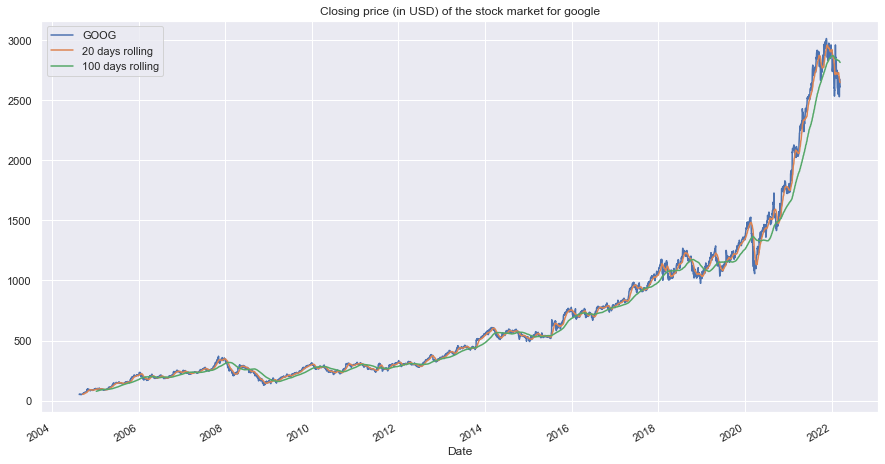

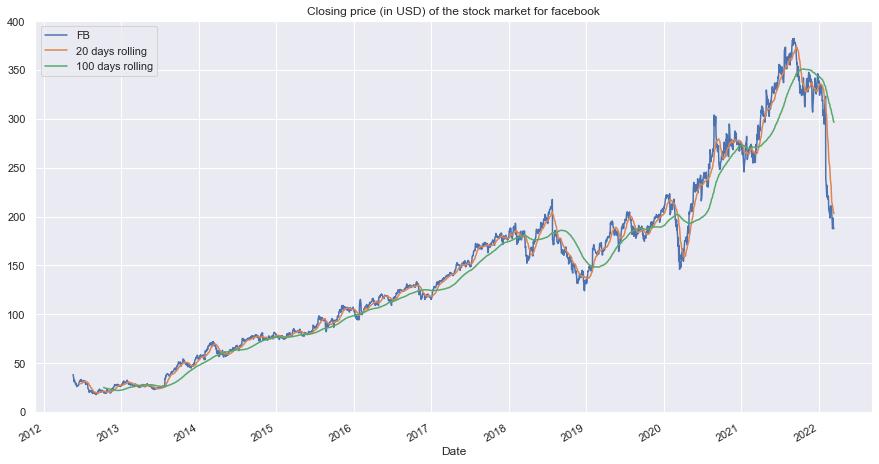

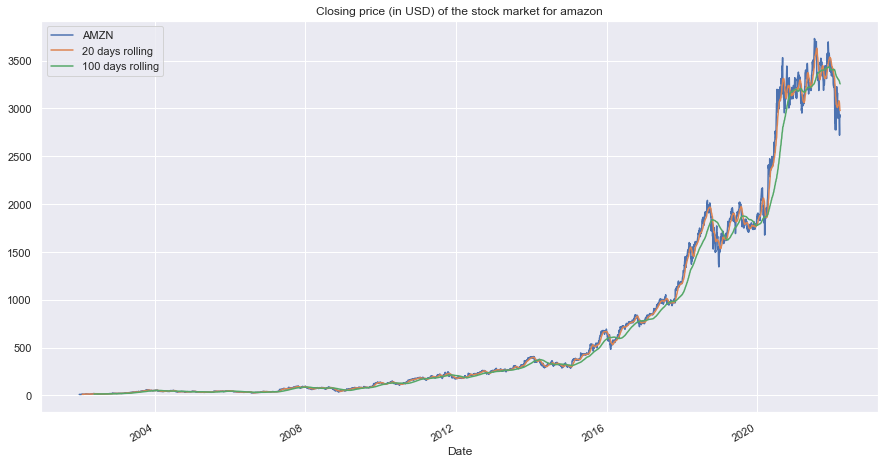

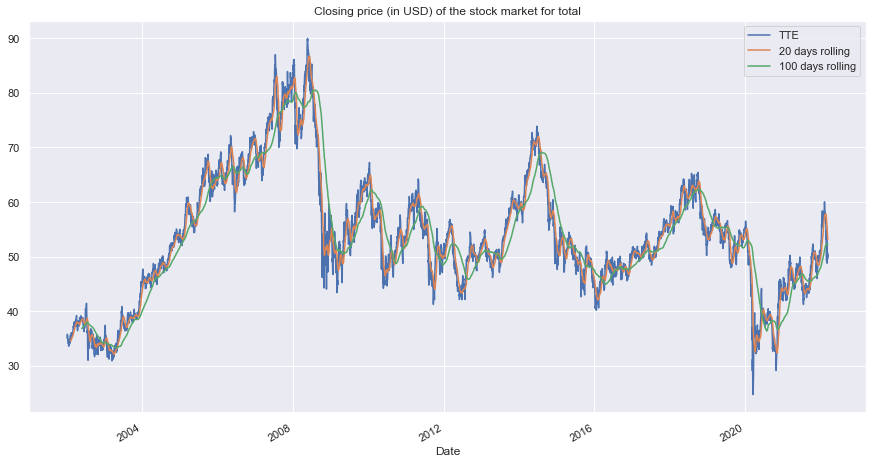

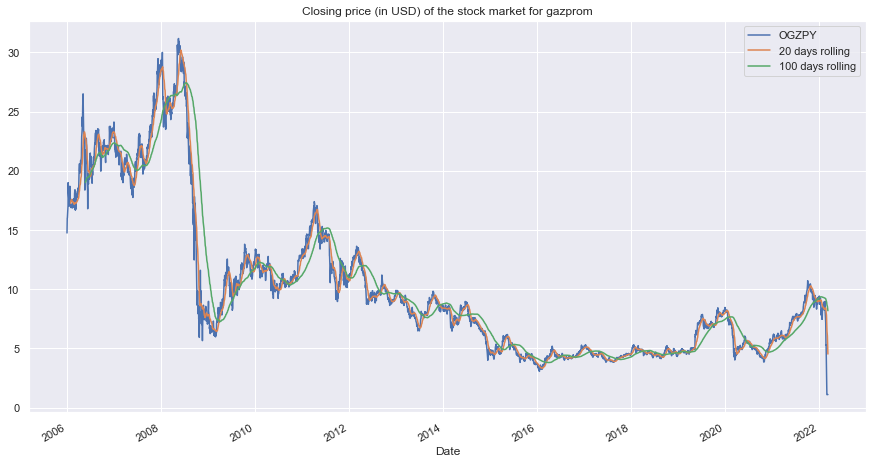

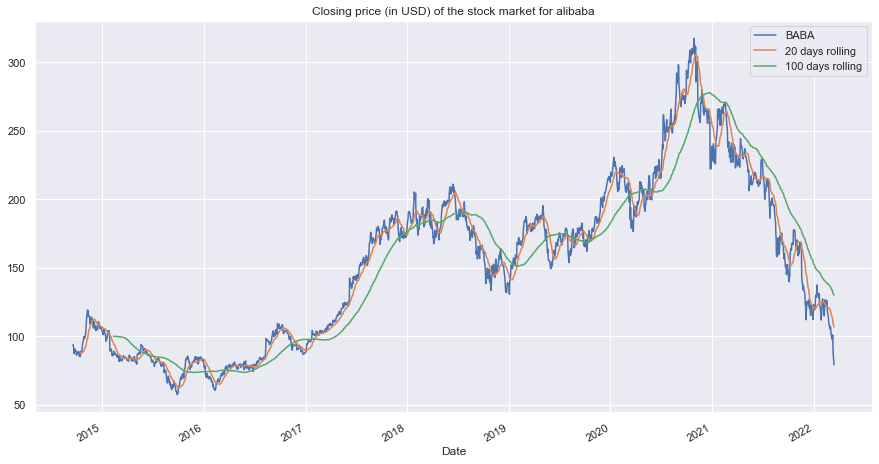

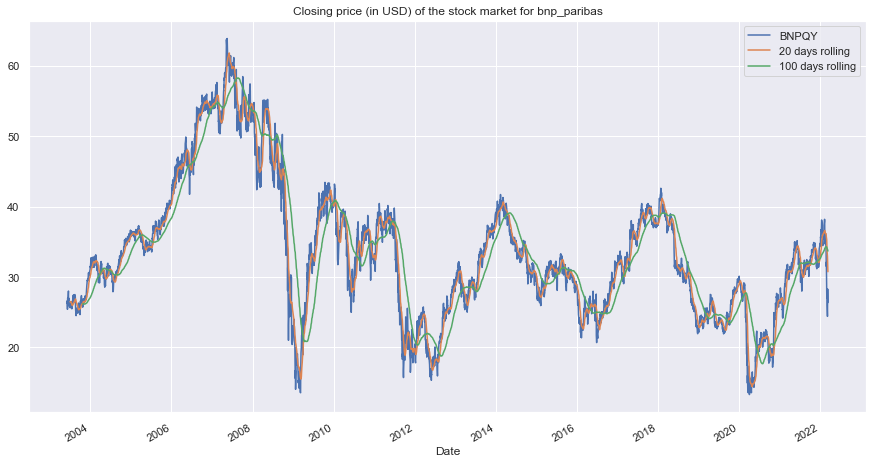

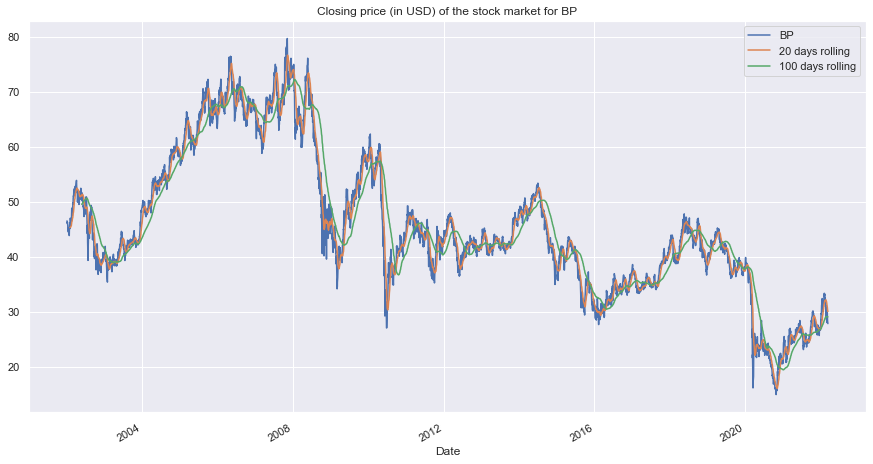

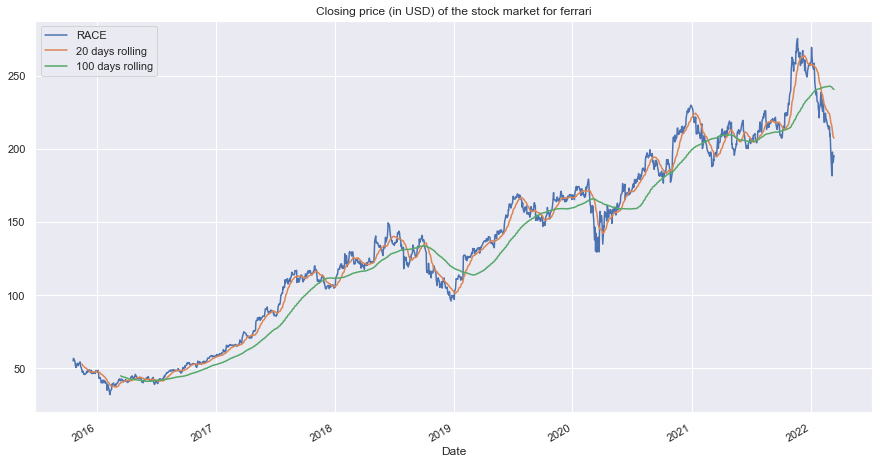

In [32]:
for company in All_the_companies:
    plot_closing(data_history, company, tick[company])

### Recent data

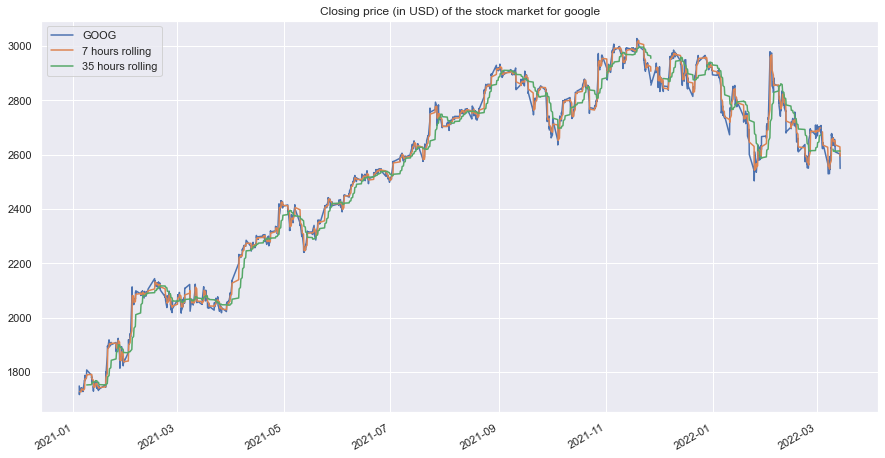

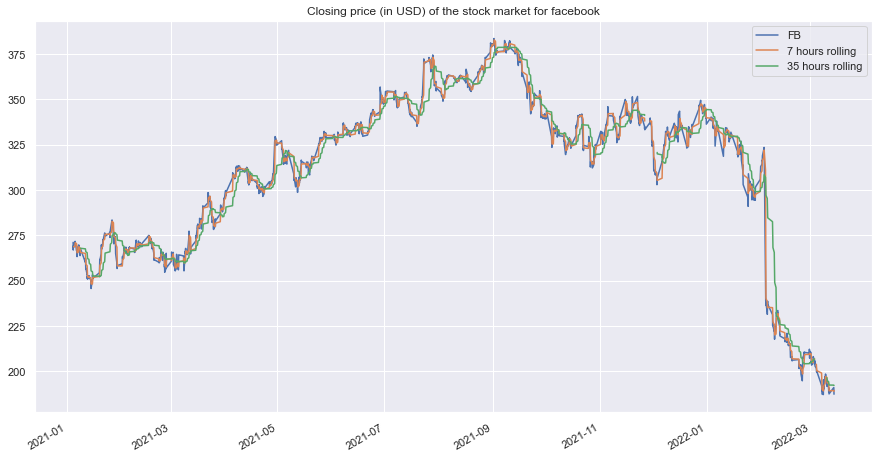

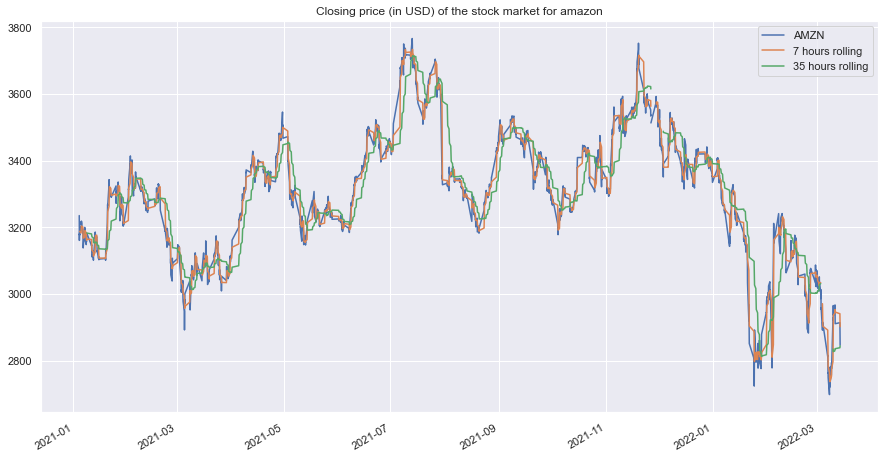

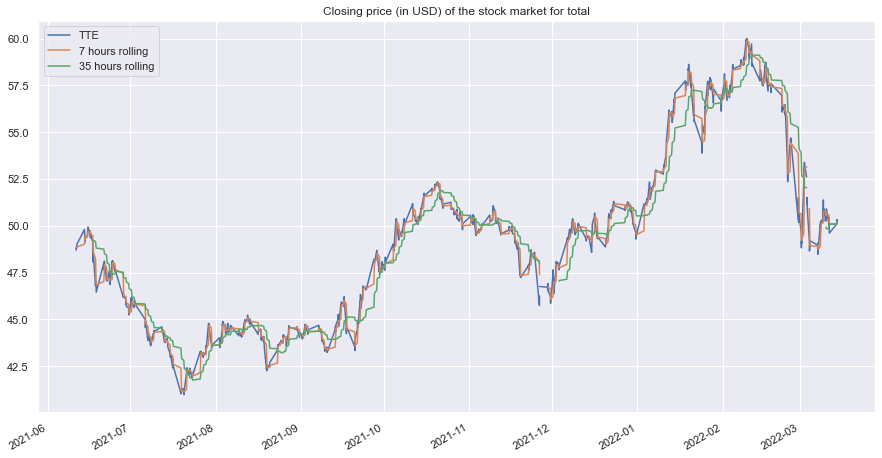

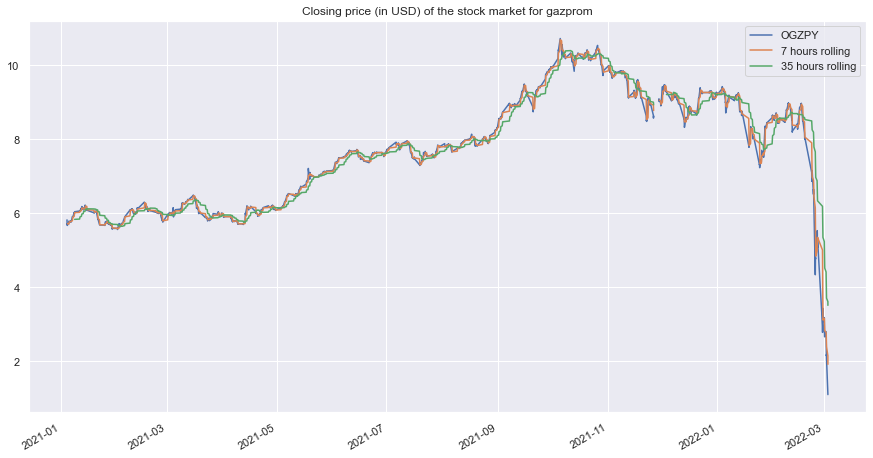

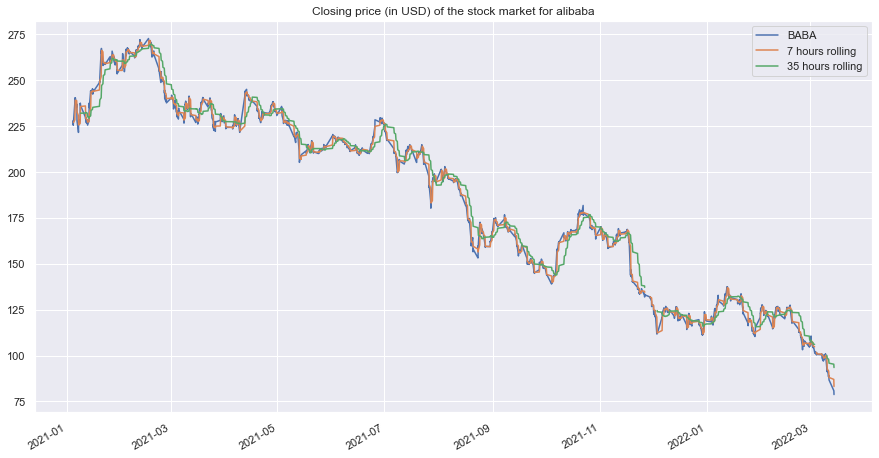

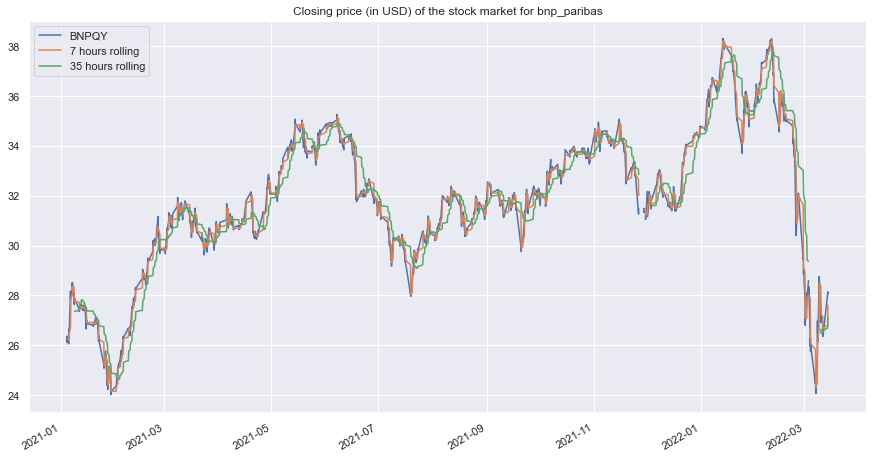

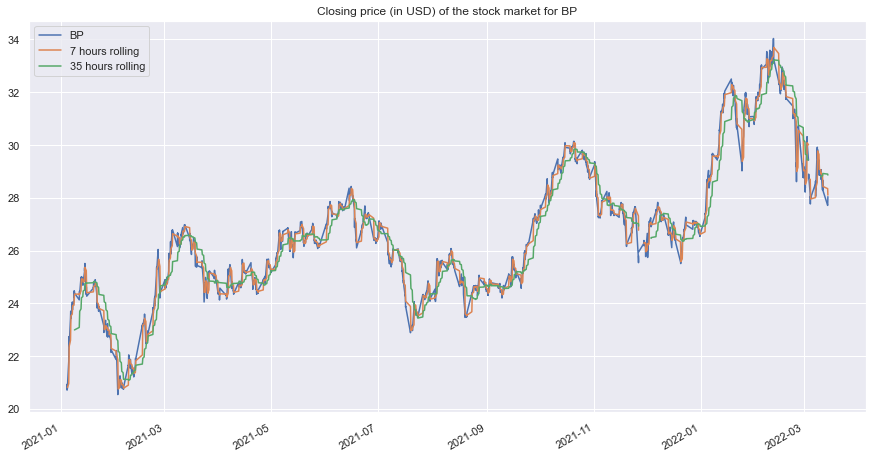

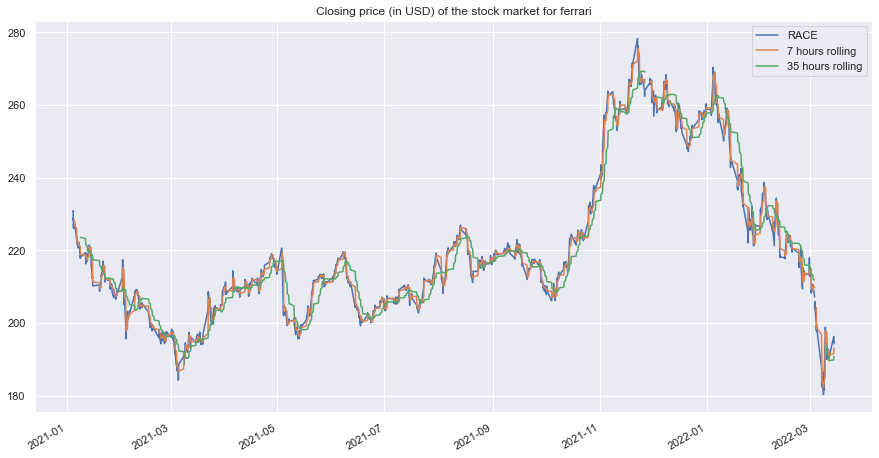

In [54]:
for company in All_the_companies:
    plot_closing(data_recent, company, tick[company], short_window=7, long_window=35, unite="hours")

# Processing of stock market data in Kafka

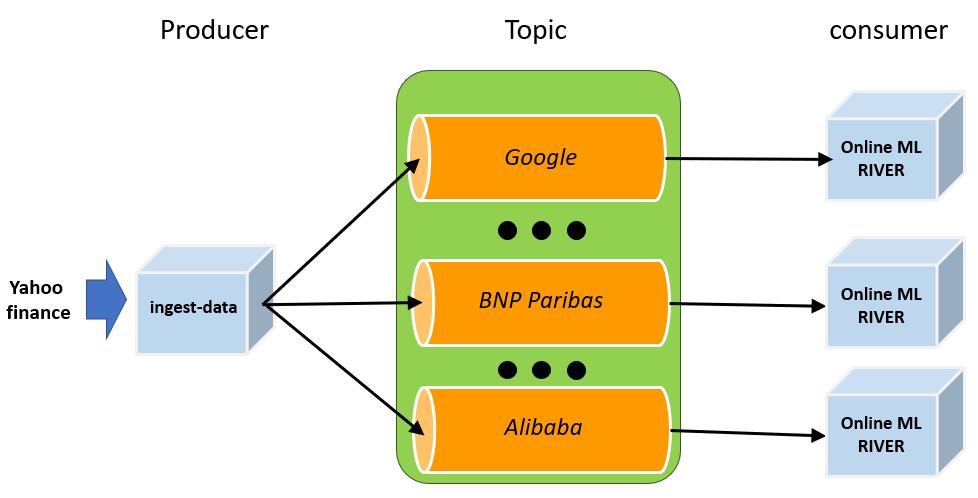

__We create a Kafka topic for each company and stream the stock data retrieved with yfinance into these topics.
In another notebook, we will retrieve this stock market data to apply a Machine Learning model with RIVER.__

## Notebook settings

In [41]:
trace_ingest_data = True
Nb_to_print = 500

## Creation of topics if needed

In [42]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id="Project_DataStream")

topic_name = {}
for company in All_the_companies:
    topic_name[company] = company

    if topic_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

## Kafka Producer : ingest_data

In [55]:
# Alias sur les données à traiter
#data = data_history
data = data_recent

In [56]:
if trace_ingest_data:
    print("-----  INGEST DATA FROM YAHOO FINANCE  ----")

pp = pprint.PrettyPrinter()
producer = KafkaProducer(bootstrap_servers="localhost:9092")

Nb_items = {}
for company in All_the_companies:
    Nb_items[company] = 0

try:
    for date, col in data.iterrows():        
        ligne = {}
        for company in All_the_companies:
            ligne[tick[company]] = {}
            ligne[tick[company]]["date"] = int(datetime.timestamp(date))*1000

        for indice in col.index:
            ligne[indice[0]][indice[1]] = col[indice]

        for company in All_the_companies:
            if not math.isnan(ligne[tick[company]]["Open"]):
                Nb_items[company] += 1
                producer.send(topic_name[company], json.dumps(ligne[tick[company]]).encode())
            
                if Nb_items[company] == 1:
                    if trace_ingest_data:
                        print("---------- {} ----------".format(company))
                        pp.pprint(ligne[tick[company]])
                        print("")

                if Nb_items[company] % Nb_to_print == 0:
                    if trace_ingest_data:
                        printmd("{} - {} records sent to the Kafka topic {}" \
                                .format(time.strftime("%d/%m/%Y %H:%M:%S"),
                                        Nb_items[company],
                                        company), couleur="blue")

except KeyboardInterrupt:
    if trace_ingest_data:
        print ("----------  END OF INGEST DATA  ----------")
except Exception as e:
    print("An arror has occurred")
    print(e)

-----  INGEST DATA FROM YAHOO FINANCE  ----
---------- google ----------
{'Adj Close': 1748.239990234375,
 'Close': 1748.239990234375,
 'High': 1760.6400146484375,
 'Low': 1740.949951171875,
 'Open': 1758.4200439453125,
 'Volume': 241052.0,
 'date': 1609770600000}

---------- facebook ----------
{'Adj Close': 271.1700134277344,
 'Close': 271.1700134277344,
 'High': 273.8999938964844,
 'Low': 269.9800109863281,
 'Open': 273.75,
 'Volume': 2708653.0,
 'date': 1609770600000}

---------- amazon ----------
{'Adj Close': 3235.080078125,
 'Close': 3235.080078125,
 'High': 3271.175048828125,
 'Low': 3217.0,
 'Open': 3271.03125,
 'Volume': 817344.0,
 'date': 1609770600000}

---------- gazprom ----------
{'Adj Close': 5.820000171661377,
 'Close': 5.820000171661377,
 'High': 5.829999923706055,
 'Low': 5.800000190734863,
 'Open': 5.809999942779541,
 'Volume': 0.0,
 'date': 1609770600000}

---------- alibaba ----------
{'Adj Close': 227.75,
 'Close': 227.75,
 'High': 230.3800048828125,
 'Low': 225.

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic google</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic facebook</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic amazon</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic gazprom</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic alibaba</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic bnp_paribas</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic BP</span>

<span style='color:blue'>14/03/2022 18:04:06 - 500 records sent to the Kafka topic ferrari</span>

---------- total ----------
{'Adj Close': 48.70000076293945,
 'Close': 48.70000076293945,
 'High': 49.5,
 'Low': 48.29999923706055,
 'Open': 49.5,
 'Volume': 170235.0,
 'date': 1623418200000}



<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic google</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic facebook</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic amazon</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic gazprom</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic alibaba</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic bnp_paribas</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic BP</span>

<span style='color:blue'>14/03/2022 18:04:07 - 1000 records sent to the Kafka topic ferrari</span>

<span style='color:blue'>14/03/2022 18:04:08 - 500 records sent to the Kafka topic total</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic google</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic facebook</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic amazon</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic gazprom</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic alibaba</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic bnp_paribas</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic BP</span>

<span style='color:blue'>14/03/2022 18:04:09 - 1500 records sent to the Kafka topic ferrari</span>

<span style='color:blue'>14/03/2022 18:04:10 - 1000 records sent to the Kafka topic total</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic google</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic facebook</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic amazon</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic gazprom</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic alibaba</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic bnp_paribas</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic BP</span>

<span style='color:blue'>14/03/2022 18:04:11 - 2000 records sent to the Kafka topic ferrari</span>